Traceback (most recent call last):
  File "C:\Anaconda37\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Anaconda37\lib\site-packages\matplotlib\backends\backend_nbagg.py", line 236, in <lambda>
    canvas.mpl_connect('close_event', lambda event: Gcf.destroy(num))
  File "C:\Anaconda37\lib\site-packages\matplotlib\_pylab_helpers.py", line 53, in destroy
    cls._activeQue.remove(manager)
ValueError: list.remove(x): x not in list


""


<IPython.core.display.Javascript object>


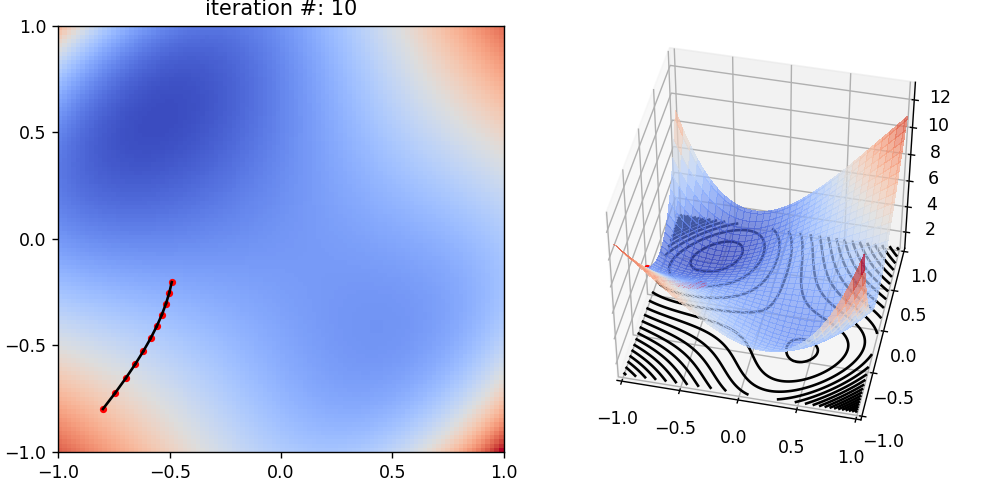

interactive(children=(HBox(children=(FloatSlider(value=0.01, description='Learning Rate', layout=Layout(border…

interactive(children=(HBox(children=(IntSlider(value=101, continuous_update=False, description='Display Resolu…

In [2]:
#%matplotlib ipympl
#import mpld3
#mpld3.enable_notebook()

try:
    shell = get_ipython().__class__.__name__
    if shell == 'ZMQInteractiveShell':
        in_ipython_flag = True  # Jupyter notebook or qtconsole
    elif shell == 'TerminalInteractiveShell':
        in_ipython_flag = True  # Terminal running IPython
    else:
        in_ipython_flag = True  # Other type (?)
except:
    in_ipython_flag = False      # Probably standard Python interpreter


if in_ipython_flag:
    mgc = get_ipython().magic
    mgc(u'%matplotlib notebook')
    # %matplotlib notebook
    from ipywidgets import Layout,HBox,VBox,interact,interactive, fixed, FloatSlider, \
                    IntSlider, Label, Checkbox, FloatRangeSlider, Button, Dropdown

    import ipywidgets as widgets
    from IPython.display import display, HTML, Math, Latex
    in_ipython_flag = True
else:
    from matplotlib.widgets import Slider, Button, RadioButtons
#%matplotlib inline
import ipython_utilities as ipu
import numpy as np
import tensorflow as tf
from sklearn import datasets
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
# from IPython.display import display, HTML, Math, Latex
# from ipywidgets import Layout,HBox,VBox,interact,interactive, fixed, FloatSlider, \
#                         IntSlider, Label, Checkbox, FloatRangeSlider, Button, Dropdown
class NthDegreePolynomial():
    def __init__(self, alpha=0.03, degree_of_polynomial=4,
                 x=np.array([[3], [2]]), resolution=101, x_limits=1,
                 f_limits=5, initial_guess=np.array([[-0.8], [-.8]]),
                optimization_method="Gradient Descent"):
        self.alpha = alpha
        self.degree_of_polynomial = degree_of_polynomial
        self.resolution = resolution
        self.x_limits=x_limits
        self.f_limits=f_limits
        self.initial_guess=initial_guess
        self.optimization_method=optimization_method
        self.div_id_for_coef="coef_div_id"
        self.div_id_for_equation="equation_div_id"
        self.create_test_polynomial_coef()
        self.create_nth_degree_2d_function()
        self.create_gui()

    def create_test_polynomial_coef(self):
        # Create a function of order degree_of_polynomial in 2-d space
        #         F(x)= (x2 – x1)**4 + 8x1x2 – x1 + x2 + 3
        #         (a - b)⁴ = a⁴- 4a³b + 6a²b² - 4ab³ + b⁴
        self.degree_of_polynomial=4
        coefficients= np.array([[3,-1,0,0,1],
                               [1,8,0,-4,0],
                               [0,0,6,0,0],
                               [0,-4,0,0,0],
                               [1,0,0,0,0]],dtype=np.int)
        self.coef=coefficients
    def display_polynomial_coef(self):
        #ipu.display_as_html_table(self.coef,"Polynomial Coefficients",div_id=self.div_id_for_coef)
        # Create Latex equation for the polynomial
        self.latex_equation='''$$ F(x_1,x_2) =  '''
        first_time=True
        for total_degree in range(self.degree_of_polynomial,-1,-1):
            for x1_row in range(total_degree,-1,-1):
                coef=self.coef[x1_row,total_degree-x1_row]
                if coef:
                    
                    if x1_row==0:
                        x1_power=''
                    elif x1_row==1:
                        x1_power='x_1'
                    else:
                        x1_power='x_1^'+str(x1_row)
                    if (total_degree-x1_row)==0:
                        x2_power=''
                    elif (total_degree-x1_row)==1:
                        x2_power='x_2'
                    else:
                        x2_power='x_2^'+str(total_degree-x1_row)
                    if coef == 1:
                        if first_time:
                            temp_latex=x1_power+x2_power
                        else:
                            temp_latex='+'+x1_power+x2_power
                    elif coef==-1:
                        temp_latex='-'+x1_power+x2_power
                    else:
                        if first_time:
                            if np.equal(np.mod(coef, 1), 0):
                                temp_latex='{:d}'.format(coef)+x1_power+x2_power
                            else:
                                temp_latex='{:0.2f}'.format(coef)+x1_power+x2_power
                        else:
                            if np.equal(np.mod(coef, 1), 0):
                                temp_latex='{:+d}'.format(coef)+x1_power+x2_power
                            else:
                                temp_latex='{:+0.2f}'.format(coef)+x1_power+x2_power
                    self.latex_equation+=temp_latex
                    first_time=False

        self.latex_equation+='$$'

        ipu.display_string_as_html_in_div(self.latex_equation,div_id=self.div_id_for_equation)

    def create_random_polynomial_coef(self):
        self.coef=np.random.random((self.degree_of_polynomial+1,self.degree_of_polynomial+1))-0.5

        
    def create_nth_degree_2d_function(self): 
        # Make the lower triangle of the opposite diagonal equal to zero 
        temp=np.fliplr(self.coef)
        temp=np.triu(np.fliplr(self.coef),k=0)
        self.coef=np.fliplr(np.triu(np.fliplr(self.coef),k=0))
        # calculate the gradient of the function
        # find the partial derivative with respect to the first variable
        temp=np.array(range(1,self.degree_of_polynomial+1)).reshape((-1,1))
        coef_partial_x1=temp*self.coef[1: ,:]
        # find the partial derivative with respect to the second variable
        coef_partial_x2=(temp*self.coef.T[1: ,:]).T
        # find the Hessian of the function
        temp_1=np.array(range(1,self.degree_of_polynomial)).reshape((-1,1))
        temp_2=np.array(range(1,self.degree_of_polynomial+1)).reshape((-1,1))
        Hessian_0_0=temp_1*coef_partial_x1[1: ,:]
        Hessian_0_1=(temp_2*coef_partial_x1.T[1: ,:]).T
        Hessian_1_0=Hessian_0_1
        Hessian_1_1=(temp_1*coef_partial_x2.T[1: ,:]).T
        self.gradient=[coef_partial_x1,coef_partial_x2]
        self.Hessian=[[Hessian_0_0,Hessian_0_1],[Hessian_1_0,Hessian_1_1]]
#         ipu.display_as_html_table(self.coef,"Polynomial Coefficients",div_id=self.div_id_for_coef)

    def reset_graphs(self):
        # Initialize the mesh grids
        self.display_polynomial_coef()
        self.x1_array = np.linspace(self.x1_min, self.x1_max, self.resolution)
        self.x2_array = np.linspace(self.x2_min, self.x2_max, self.resolution)
        self.x1_mesh, self.x2_mesh = np.meshgrid(self.x1_array, self.x2_array)
        self.calculate_f_on_grid()
        self.f_min=self.f.min()
        self.f_max=self.f.max()
        #plt.clf()
        #plt.cla()
        self.ax0.clear()
        self.ax1.clear()
        self.ax0.set_xlim(self.x1_min, self.x1_max)
        self.ax0.set_ylim(self.x2_min, self.x2_max)
        
        self.ax1.set_xlim(self.x1_min, self.x1_max)
        self.ax1.set_ylim(self.x2_min, self.x2_max)
        self.ax1.set_zlim(self.f_min, self.f_max)

        self.iteration_number = 0
        self.current_x = self.initial_guess
        self.previous_x=self.current_x
        self.display_f()
        self.display_delta_x()
#         self.display_polynomial_coef()
    def display_f(self):
        #plt.close()
        temp = self.f_mesh[:-1, :-1]
        colormap = plt.cm.coolwarm
        znorm = temp - temp.min()
        znorm /= znorm.ptp()
        color = colormap(znorm)
        self.colormesh = self.ax0.pcolormesh(self.x1_mesh, self.x2_mesh, znorm, cmap=colormap)
        #self.surf = self.ax1.plot_surface(self.x1_mesh, self.x2_mesh, self.f_mesh, cmap=plt.cm.coolwarm,
        #                                  linewidth=0, antialiased=False,alpha=0.5)
        self.surf = self.ax1.plot_surface(self.x1_mesh, self.x2_mesh, self.f_mesh, cmap=plt.cm.coolwarm,
                                          linewidth=0, antialiased=False,alpha=0.7)
        self.ax1.contour(self.x1_mesh, self.x2_mesh, self.f_mesh, 20,  colors="K", linestyles="solid",
                         offset=self.f_min)
        self.ax1.set_zlim(self.f_min, self.f_max)
        self.ax1.locator_params(axis='x', nbins=5)
        self.ax1.locator_params(axis='y', nbins=5)
        self.fig.canvas.draw()
        self.ax0.set_title("iteration #: " + str(self.iteration_number))
        self.ax0.locator_params(axis='x', nbins=5)
        self.ax0.locator_params(axis='y', nbins=5)
        if in_ipython_flag:
            plt.show(block=False)
            #plt.pause(0.01)
            plt.show()
            plt.pause(0.01)
#             self.fig.canvas.draw()
#             time.sleep(0.001)
        else:
            plt.show()
            plt.pause(0.01)
        #plt.clf()

    def create_gui(self):
#         divs='''<div style="width: 100%; display: table;">
#     <div style="display: table-row">
#         <div id="'''+self.div_id_for_coef+'''"style="width: %50; display: table-cell;"> Left </div>
#         <div id="'''+self.div_id_for_equation+'''"style="width: %50; display: table-cell;"> Right </div>
#     </div>
# </div>'''
#         divs='''<body><table><div style="width: 100%; overflow: hidden;">
#     <div id="'''+self.div_id_for_coef+'''" style="width: 50%; float: left;"> Left </div>
#     <div id="'''+self.div_id_for_equation+'''" style="color:red;  ">
#       </div>
# </div></table></body>'''

        divs='''<body><table style="float:center; width: 80%"><caption> Polynomial </caption><tr><td>
        <div id="'''+self.div_id_for_equation+'''" style="color:red;  "></div>
</td></tr></table></body>'''

        display(HTML(divs))
#         display(Math(r'F(k) = \int_{-\infty}^{\infty} f(x) e^{2\pi i k} dx'))
#         print(HTML(Math(r'F(k) = \int_{-\infty}^{\infty} f(x) e^{2\pi i k} dx')))
        self.x1_min = -self.x_limits
        self.x1_max = self.x_limits
        self.x2_min = -self.x_limits
        self.x2_max = self.x_limits
        self.f_min = -self.f_limits
        self.f_max = self.f_limits
        plt.ion()
#         self.fig = plt.figure()
        self.fig = plt.figure(figsize=(8,4))
        
#         X, Y = self.fig.get_dpi() * self.fig.get_size_inches()
#         print("Size",X,Y)
#         print("DPI=",self.fig.get_dpi)
        self.ax0 = self.fig.add_subplot(121)
        self.ax1 = self.fig.add_subplot(122, projection='3d')
        self.ax1.set_zlim(self.f_min, self.f_max)
        plt.tight_layout()
        plt.ion()
        

    def calculate_f_on_grid(self):
        self.f=np.polynomial.polynomial.polygrid2d(self.x1_array,self.x2_array, self.coef.T)
        self.f_mesh = self.f.reshape(self.x1_mesh.shape)

    def calculate_f_at_x(self,x):
        return np.polynomial.polynomial.polyval2d(x[0][0],x[1][0], self.coef)
    def display_delta_x(self):
        above_surface_displacement=0.01*(self.f_max-self.f_min)
        previous_f=self.calculate_f_at_x(self.previous_x)
        current_f=self.calculate_f_at_x(self.current_x)
        self.ax1.scatter(self.current_x[0], self.current_x[1],current_f+above_surface_displacement,c='r',s=10)
        self.ax1.plot(np.array([self.previous_x[0],self.current_x[0] ]),
                      np.array([self.previous_x[1],self.current_x[1] ]),
                      np.array([previous_f+above_surface_displacement,current_f+above_surface_displacement ]),color='black',linewidth=2,alpha=2.0,linestyle="-")
        self.ax1.set_zlim(self.f_min, self.f_max)
        self.ax0.scatter(self.current_x[0], self.current_x[1],c='r',s=10)
        self.ax0.plot(np.array([self.current_x[0], self.previous_x[0]]),
                      np.array([self.current_x[1], self.previous_x[1]]), color="K")
        self.ax0.set_title("iteration #: " + str(self.iteration_number))
        plt.show()

 
    def change_parameters_no_initialization(self,alpha=0.1,iterations=10,degree_of_polynomial=2,optimization_method="Gradient Descent"):
        self.alpha=alpha
        self.iterations=iterations
        self.degree_of_polynomial=degree_of_polynomial      
        self.optimization_method=optimization_method
    def change_parameters_with_initialization(self,resolution=100,x_limits=1):        
        self.resolution=resolution
        self.x_limits=x_limits
        self.x1_min = -self.x_limits
        self.x1_max = self.x_limits
        self.x2_min = -self.x_limits
        self.x2_max = self.x_limits
#         print(self.resolution,self.x2_max)
        self.reset_graphs()
#         self.display_polynomial_coef()
    def calculate_gradient_at_current_point(self):
        self.gradient_at_current_point=np.array( \
                [[np.polynomial.polynomial.polyval2d(self.current_x[0],self.current_x[1],self.gradient[0])[0]],
        [np.polynomial.polynomial.polyval2d(self.current_x[0],self.current_x[1],self.gradient[1])[0]]])
    
#         self.gradient = np.dot(self.A, self.current_x) + self.d
    def calculate_Hessian_at_current_point(self):
        self.Hessian_at_current_point=np.array(\
                        [[np.polynomial.polynomial.polyval2d(self.current_x[0],self.current_x[1],self.Hessian[0][0])[0],
                       np.polynomial.polynomial.polyval2d(self.current_x[0],self.current_x[1],self.Hessian[0][1])[0]],
                        [np.polynomial.polynomial.polyval2d(self.current_x[0],self.current_x[1],self.Hessian[1][0])[0],
                       np.polynomial.polynomial.polyval2d(self.current_x[0],self.current_x[1],self.Hessian[1][1])[0]] ])
    def search_for_minima(self,button):
        #self.display_delta_x()
        for k in range(self.iterations):
            self.calculate_gradient_at_current_point()
            self.previous_x = self.current_x
            if self.optimization_method=="Gradient Descent":

                self.current_x = self.current_x - self.alpha * self.gradient_at_current_point
            elif self.optimization_method=="Search Along a Line":
                self.calculate_Hessian_at_current_point()
                alpha_k=np.dot(self.gradient_at_current_point.T,
                            self.gradient_at_current_point)/(np.dot(self.gradient_at_current_point.T,
                                np.dot(self.Hessian_at_current_point,self.gradient_at_current_point)))
                self.current_x = self.current_x - alpha_k * self.gradient_at_current_point
                
            
            self.iteration_number += 1
            self.display_delta_x()
            # print(k)
            if in_ipython_flag:
                self.fig.canvas.draw()
                time.sleep(0.2)
                plt.pause(0.2)
            else:
                plt.show()
                plt.pause(0.01)        
    def random_polynomial(self,button):
        self.create_random_polynomial_coef()
        #self.initial_guess=2*self.x_limits* (np.random.random((2,1))-0.5)
        self.create_nth_degree_2d_function()
        self.reset_graphs()
        
        self.reset_graphs()
    def reset_polynomial(self,button):
        self.initial_guess=np.array([[-0.8], [-.8]])
        #self.initial_guess=2*self.x_limits* (np.random.random((2,1))-0.5)
        coefficients= np.array([[3,-1,0,0,1],
                               [1,8,0,-4,0],
                               [0,0,6,0,0],
                               [0,-4,0,0,0],
                               [1,0,0,0,0]],dtype=np.int)
        self.coef=coefficients
        
        
        self.create_nth_degree_2d_function()
        self.reset_graphs()
    def random_initial_point(self,button):
        self.initial_guess=2*self.x_limits* (np.random.random((2,1))-0.5)
        self.reset_graphs()

if __name__ == "__main__":
    nth_degree_polynomial = NthDegreePolynomial()
    plt.ioff()
    plt.show()
    style = {'description_width': '40%','handle_color' : 'lightblue'}
    layout=Layout(width='50%')
    interactive_parameters_no_initialization=interactive(nth_degree_polynomial.change_parameters_no_initialization, 
                alpha=FloatSlider(min=0.0,max=1.0,step=0.0001,
                value=0.01,description='Learning Rate',style=style,layout=layout),
                iterations=IntSlider(min=1,max=100,step=1,
                value=10,description='Num. of Iterations',style=style,layout=layout),
              optimization_method=Dropdown(options=["Gradient Descent","Search Along a Line",
                                "Newton's Method", "Conjugate Gradient"],
                                    value="Gradient Descent",style=style,layout=layout,
                                description="Search Method",continuous_update=False),
                                                         degree_of_polynomial=IntSlider(min=2,max=10,step=1,
                value=4,description='Degree of Polynomial',style=style,layout=layout) )
    interactive_parameters_with_initialization = interactive(nth_degree_polynomial.change_parameters_with_initialization,
                resolution=IntSlider(min=5,max=400,step=1,
                value=101,description='Display Resolution',style=style,layout=layout,continuous_update=False),
                x_limits=FloatSlider(min=0.5,max=20,step=0.1,
                value=1,description='X Limits',style=style,layout=layout,continuous_update=False))
    button_layout=Layout(width='50%',border='1px solid red')
    search_btn = Button(description="Search",layout=button_layout)
    search_btn.on_click(nth_degree_polynomial.search_for_minima)
    random_polynomial_button=Button(description="Create Random Polynomial",layout=button_layout)
    random_polynomial_button.on_click(nth_degree_polynomial.random_polynomial)
    random_initial_point_button=Button(description="Random Initial Point",layout=button_layout)
    random_initial_point_button.on_click(nth_degree_polynomial.random_initial_point)
    reset_button=Button(description="Reset Graphs",layout=button_layout)
    reset_button.on_click(nth_degree_polynomial.reset_polynomial)
    
    display(HBox([search_btn,random_polynomial_button,random_initial_point_button,reset_button]))
    ipu.arrange_widgets_in_grid(interactive_parameters_no_initialization)
    ipu.arrange_widgets_in_grid(interactive_parameters_with_initialization)